# Orbital Transfer via Trajectory Optimization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from pydrake.all import MathematicalProgram, PiecewisePolynomial, SnoptSolver

# increase default size matplotlib figures
rcParams["figure.figsize"] = (8, 5)

## Problem Description

In this problem we'll solve for trajectories that efficiently transfer a rocket from the Earth to Mars, while avoiding a huge cloud of asteroids.
We'll make a few simplifying assumptions about the world we're in:
- the galaxy is 2D,
- the planets are point masses and do not move,
- planet orbits are circular.

We are not satisfied with the current trajectory we get from the nonlinear optimizer.
Your role is to improve our trajectory by:
- enforcing state and input limits,
- minimizing the fuel consumption, and, more importantly,
- avoiding asteroids!

You'll be given more details on this later in the notebook.

Let's start deciding the units of measurements we'll use in this problem: this is a fundamental step to prevent the solver from having numeric issues.

In [2]:
# dictionary of functions to convert the units of the problem data
# the fist argument is the numeric value we want to convert
# the second argument is the unit power
# e.g., m = 2 and power = 2 for square meters
unit_converter = {
    "mass": lambda m, power=1: m / 1e3**power,  # takes kilos, returns tons
    "length": lambda l, power=1: l
    / 1e11**power,  # takes meters, returns hundreds of gigameters
    "time": lambda t, power=1: t
    / (60 * 60 * 24 * 30 * 12) ** power,  # takes seconds, returns years
}

## Model of the 2D Universe

Let's start by setting up the rocket.
We're lucky enough to have in our hands a [SpaceX Falcon 9 rocket](https://www.spacex.com/vehicles/falcon-9).

Unfortunately, we spent most of the budget buying the rocket, and we can't afford much fuel.
For this reason we put ridiculously tight limits on the maximum thrust and velocity.
The plan is to arrive to Mars in 50 years...

(The true reason for these tiny limits is a mixture of modeling and numeric issues. If you feel like, give the true [Falcon 9 specs](https://www.spacex.com/vehicles/falcon-9) a try!)

In [3]:
# simple class to store the rocket data


class Rocket(object):
    def __init__(
        self,
        mass,  # mass of the rocket in kg
        thrust_limit,  # max norm of the thrust in kg * m * s^-2
        velocity_limit,  # max norm of the velocity in m * s^-1
    ):
        # store mass using the scaled units
        self.mass = unit_converter["mass"](mass)

        # store thrust limit converting the units one by one
        thrust_units = [("mass", 1), ("length", 1), ("time", -2)]
        for quantity, power in thrust_units:
            thrust_limit = unit_converter[quantity](thrust_limit, power)
        self.thrust_limit = thrust_limit

        # store velocity limit converting the units one by one
        velocity_units = [("length", 1), ("time", -1)]
        for quantity, power in velocity_units:
            velocity_limit = unit_converter[quantity](velocity_limit, power)
        self.velocity_limit = velocity_limit


# instantiate the rocket
rocket = Rocket(
    5.49e5,  # mass of Falcon 9 in kg
    0.25,  # very small thrust limit in kg * m * s^-2
    170,  # very small velocity limit in m * s^-1
)

Now it's time to code the `Planet` class.
The Earth and Mars will be instances of this class, as well as the asteroids.

This class has a parameter called `orbit`.
For the Earth, this is the radius of the orbit from which our mission starts.
For Mars, this is the radius of the target orbit.
For the asteroids, this is the radius of a "danger area" centered at the asteroid itself that we want our rocket to avoid.

In [4]:
# each planet/asteroid in the problem must be an instance of this class


class Planet(object):
    def __init__(
        self,
        name,  # string with the name of the planet
        color,  # color of the planet for plots
        mass,  # mass of the planet in kg
        position,  # position of the planet in the 2d universe in m
        orbit,  # radius of the orbit in m
        radius=np.nan,  # radius of the planet in m (optional)
    ):
        # store the data using the scaled units
        self.name = name
        self.mass = unit_converter["mass"](mass)
        self.position = unit_converter["length"](position)
        self.radius = unit_converter["length"](radius)
        self.orbit = unit_converter["length"](orbit)
        self.color = color


# planet Earth: https://en.wikipedia.org/wiki/Earth
earth = Planet(
    "Earth",  # name of the planet
    "green",  # color for plot
    5.972e24,  # mass in kg
    np.array([2.25e11, 0]),  # (average) distance wrt Mars in m
    2e10,  # orbit radius in m (chosen "big enough" for the plots)
    6.378e6,  # planet radius in m
)

# planet Mars: https://en.wikipedia.org/wiki/Mars
mars = Planet(
    "Mars",  # name of the planet
    "red",  # color for plot
    6.417e23,  # mass in kg
    np.zeros(2),  # Mars is chosen as the origin of our 2D universe
    1.5e10,  # orbit radius in m
    3.389e6,  # radius in m
)

# asteroids with random data in random positions
np.random.seed(0)
n_asteroids = 10
asteroids = []
for i in range(n_asteroids):
    mass = np.abs(np.random.randn()) * 5e22
    orbit = mass / 5e12
    earth_from_mars = unit_converter["length"](earth.position, -1)
    asteroid_from_mars = np.random.randn(2) * 3e10 + earth_from_mars / 2
    asteroids.append(
        Planet(
            f"Asteroid_{i}",  # name of the planet
            "brown",  # color for plot
            mass,  # mass in kg
            asteroid_from_mars,  # distance from Mars in m
            mass / 5e12,  # radius danger area in m
        )
    )

Let's put all the pieces together in ours 2D universe.
The class `Universe` also implements some utility functions that will be helpful when setting up the optimization problem.
For example, for the piece of code you'll be asked to write, you might consider using the `position_wrt_planet` method.

In [5]:
# main class of the notebook
# it collects the rocket, the planets, and all the asteroids
# implements utility functions needed to write the trajopt


class Universe(object):
    def __init__(
        self,
        rocket,
        planets,  # instance of Rocket  # list of instances of Planet
    ):
        # store data
        self.rocket = rocket
        self.planets = planets

        # gravitational constant in m^3 * kg^-1 * s^-2
        self.G = 6.67e-11

        # gravitational constant in the scaled units
        G_units = [("length", 3), ("mass", -1), ("time", -2)]
        for quantity, power in G_units:
            self.G = unit_converter[quantity](self.G, power)

    # given the planet name, returns the Planet instance
    def get_planet(self, name):
        # loop through the planets in the universe
        for planet in self.planets:
            if planet.name == name:
                return planet

        # in case no planet has the given name
        print(name + " is not in the Universe!")

    # computes  2D distance vector between the rocket and a planet,
    # given the rocket state and the planet name
    def position_wrt_planet(self, state, name):
        # rocket position wrt to the planet position
        planet = self.get_planet(name)
        p = state[:2] - planet.position

        return p

    # computes the rocket acceleration due to a planet
    def acceleration_from_planet(self, state, name):
        # distance from the planet
        p = self.position_wrt_planet(state, name)
        d = p.dot(p) ** 0.5

        # 2d acceleration vector
        planet = self.get_planet(name)
        a = -self.G * planet.mass / d**3 * p

        return a

    # right-hand side of the rocket continuous-time dynamics
    # in the form state_dot = f(state, thrust)
    # (thrust is a 2D vector with the horizontal and vertical thrusts)
    def rocket_continuous_dynamics(self, state, thrust):
        # thrust acceleration
        a = thrust / self.rocket.mass

        # accelerations due to the planets
        for planet in self.planets:
            a = a + self.acceleration_from_planet(state, planet.name)

        # concatenate velocity and acceleration
        state_dot = np.concatenate((state[2:], a))

        return state_dot

    # residuals of the rocket discrete-time dynamics
    # if the vector of residuals is zero, then this method's
    # arguments verify the discrete-time dynamics
    # (implements the implicit Euler integration scheme:
    # https://en.wikipedia.org/wiki/Backward_Euler_method)
    def rocket_discrete_dynamics(self, state, state_next, thrust, time_step):
        # continuous-time dynamics evaluated at the next time step
        state_dot = self.rocket_continuous_dynamics(state_next, thrust)

        # implicit-Euler state update
        residuals = state_next - state - time_step * state_dot

        return residuals

    # helper function for the trajopt problem
    # if the vector of residuals is zero, then the state of
    # the rocket belongs to the desired orbit of the given planet
    # (i.e.: the rocket is on the given orbit, with zero radial
    # velocity, and zero radial acceleration)
    def constraint_state_to_orbit(self, state, planet_name):
        # unpack state, rocket position in relative coordinates
        planet = self.get_planet(planet_name)
        p = state[:2] - planet.position
        v = state[2:]

        # constraint on radial distance
        # sets x^2 + y^2 to the orbit radius squared
        residual_p = p.dot(p) - planet.orbit**2

        # radial velocity must be zero
        # sets the time derivative of x^2 + y^2 to zero
        residual_v = p.dot(v)

        # radial acceleration must be zero with zero input
        # sets the second time derivative of x^2 + y^2 to zero
        # why this extra constraint?
        # knowing that the radial velocity is zero is not enough
        # the tangential velocity must be such that the gravitational
        # force is balanced by the centrifugal force
        a = self.acceleration_from_planet(state, planet_name)
        residual_a = p.dot(a) + v.dot(v)

        # gather constraint residuals
        residuals = np.array([residual_p, residual_v, residual_a])

        return residuals

    # bonus method! (not actually needed in the trajopt...)
    # computes the gravity acceleration on the surface of a planet
    def gravity_on_planet_surface(self, name):
        # retrieve planet
        planet = self.get_planet(name)
        if planet is not None:
            # if planet radius is not available
            if np.isnan(planet.radius):
                print(name + " has unknown radius.")
                return

            # use Newton's law of universal gravitation
            g = self.G * planet.mass / planet.radius**2

            # use the converter the other way around
            # to express g in MKS
            g_inverse_units = [("length", -1), ("time", 2)]
            for quantity, power in g_inverse_units:
                g = unit_converter[quantity](g, power)

            # print the result
            print("Gravity acceleration on " + name + f" is {g} m/s^2.")


# instantiate universe
planets = [earth, mars] + asteroids
universe = Universe(rocket, planets)

## Double Check the Physics

Just to be sure that things make sense, let's compute the gravity accelerations on the surface of the planets in our 2D universe.
Are these values close to what you expect?

In [6]:
universe.gravity_on_planet_surface("Earth")
universe.gravity_on_planet_surface("Mars")
universe.gravity_on_planet_surface("Jupiter")

Gravity acceleration on Earth is 9.79211720754188 m/s^2.
Gravity acceleration on Mars is 3.7266167832836374 m/s^2.
Jupiter is not in the Universe!


## Plot Functions

Here are some plot functions that will help us visualizing the results.
You'll find these useful when improving the trajectory as explained below.
As always, no need to fully understand what's going on here, unless you're a `matplotlib` enthusiast...

In [7]:
# helper function that plots a circle centered at
# the given point and with the given radius


def plot_circle(center, radius, *args, **kwargs):
    # discretize angle
    angle = np.linspace(0, 2 * np.pi)

    # plot circle
    plt.plot(
        center[0] + radius * np.cos(angle),
        center[1] + radius * np.sin(angle),
        *args,
        **kwargs
    )


# function that draws the state-space trajectory of the rocket
# including the planets and the asteroids
def plot_state_trajectory(trajectory, universe):
    for planet in universe.planets:
        # plot planets
        plt.scatter(*planet.position, s=100, c=planet.color)
        plt.text(*planet.position, planet.name)

        # plot orbits
        if not np.isnan(planet.orbit):
            if planet.name == "Asteroid_1":
                orbit_label = "Asteroid danger area"
            elif planet.name[:8] == "Asteroid":
                orbit_label = None
            else:
                orbit_label = planet.name + " orbit"
            plot_circle(
                planet.position,
                planet.orbit,
                label=orbit_label,
                color=planet.color,
                linestyle="--",
            )

    # plot rocket trajectory
    plt.plot(trajectory.T[0], trajectory.T[1], color="k", label="Rocket trajectory")
    plt.scatter(trajectory[0, 0], trajectory[0, 1], color="k")

    # misc settings
    length_unit = unit_converter["length"](1)
    plt.xlabel("{:.0e} meters".format(length_unit))
    plt.ylabel("{:.0e} meters".format(length_unit))
    plt.grid(True)
    plt.gca().set_aspect("equal")

    # legend
    n_legend = len(plt.gca().get_legend_handles_labels()[0])
    plt.legend(
        loc="upper center",
        ncol=int(n_legend / 2),
        bbox_to_anchor=(0.5, 1.25),
        fancybox=True,
        shadow=True,
    )


# function that plots the norm of the rocket thrust and
# velocity normalized on their maximum value
def plot_rocket_limits(rocket, thrust, state):
    # reconstruct time vector
    time_steps = thrust.shape[0]
    time = np.linspace(0, time_steps, time_steps + 1)

    # plot maximum norm limit
    plt.plot(time, np.ones(time_steps + 1), "r--", label="Limit")

    # plot normalized thrust
    thrust_norm = [np.linalg.norm(t) / rocket.thrust_limit for t in thrust]
    plt.step(time, [thrust_norm[0]] + thrust_norm, label="Thrust / thrust limit")

    # plot normalized velocity
    velocity_norm = [np.linalg.norm(v) / rocket.velocity_limit for v in state[:, 2:]]
    plt.plot(time, velocity_norm, label="Velocity / velocity limit")

    # plot limits
    plt.xlim(0, time_steps)
    ymax = max(1, max(thrust_norm), max(velocity_norm)) * 1.05
    plt.ylim(0, ymax)

    # misc settings
    plt.xlabel("Time step")
    plt.grid(True)
    plt.legend()

## Trajectory Optimization

We start writing a simple function to generate an initial guess for the trajectory of the rocket state.

We just draw a straight line from the Earth to Mars.
This does not verify our constraints, but we let the solver think about the details...
We just need to give it a rough idea of how we want the final trajectory to look like.

Note that we also add a tiny amount of randomness to the initial guess.
This is needed since a straight line from the Earth to Mars would have the initial and the final knot points in the centers of the planets.
There, the Gravitational force is infinite, and the solver would crash at the first iteration!

In [8]:
# function that interpolates two given positions of the rocket
# velocity is set to zero for all the times


def interpolate_rocket_state(p_initial, p_final, time_steps):
    np.random.seed(0)

    # initial and final time and state
    time_limits = [0.0, time_steps * time_interval]
    position_limits = np.column_stack((p_initial, p_final))
    state_limits = np.vstack((position_limits, np.zeros((2, 2))))

    # linear interpolation in state
    state = PiecewisePolynomial.FirstOrderHold(time_limits, state_limits)

    # sample state on the time grid and add small random noise
    state_guess = np.vstack(
        [state.value(t * time_interval).T for t in range(time_steps + 1)]
    )
    state_guess += np.random.rand(*state_guess.shape) * 5e-6

    return state_guess

Now it's finally time to write the trajectory optimization problem.
Here is the skeleton of it.
So far we just:
- defined the optimization variables,
- enforced the initial and terminal constraints,
- required the rocket to satisfy the discretized dynamics we defined above,
- set the state initial guess.

**Note:**
In this notebook we write the trajectory optimization as a generic `MathematicalProgram`.
This because we want your hands to get dirty at least once, and see in detail how these optimization problems are constructed.
Having said this, Drake provides faster and cleaner ways to write down trajectory optimization problems.
If you are interested, have a look at the class [`DirectCollocation`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1planning_1_1trajectory__optimization_1_1_direct_collocation.html) and at the chapter notebook.

**Troubleshooting:**
We've split the setup and the solution of the optimization problem in multiple cells.
This is needed for you to fill in the missing pieces.
Note that after you've done your modifications to the mathematical program, you'll need to rerun all the cells starting from the one below, where the `MathematicalProgram` is initialized.

In [9]:
# numeric parameters
time_interval = 0.5  # in years
time_steps = 100

# initialize optimization
prog = MathematicalProgram()

# optimization variables
state = prog.NewContinuousVariables(time_steps + 1, 4, "state")
thrust = prog.NewContinuousVariables(time_steps, 2, "thrust")

# initial orbit constraints
for residual in universe.constraint_state_to_orbit(state[0], "Earth"):
    prog.AddConstraint(residual == 0)

# terminal orbit constraints
for residual in universe.constraint_state_to_orbit(state[-1], "Mars"):
    prog.AddConstraint(residual == 0)

# discretized dynamics
for t in range(time_steps):
    residuals = universe.rocket_discrete_dynamics(
        state[t], state[t + 1], thrust[t], time_interval
    )
    for residual in residuals:
        prog.AddConstraint(residual == 0)

# initial guess
state_guess = interpolate_rocket_state(
    universe.get_planet("Earth").position,
    universe.get_planet("Mars").position,
    time_steps,
)
prog.SetInitialGuess(state, state_guess)

Here is an empty cell for you to work in: detailed instructions are given below.
For the moment just run it as it is and continue to the plots.

**Troubleshooting:**
If you run the following cell multiple times, you keep adding more and more constraints to the optimization problem.
Hence, after you modify the code in the cell below, rerun the cell above to start with a fresh `MathematicalProgram`.

In [10]:
# thrust limits, for all t:
# two norm of the rocket thrust
# lower or equal to the rocket thrust_limit

# initial guess for thrust, otherwise, the solver breaks due to division by zero.
# if the initial gusse is 1 or thrust_limit the performance is bad, lesser the initial guess, better the performance?
prog.SetInitialGuess(thrust, 0.01*np.ones((time_steps,2)))

# modify here
for t in range(time_steps):
    norm_thrust = thrust[t].dot(thrust[t]) ** 0.5
    prog.AddConstraint(norm_thrust <= universe.rocket.thrust_limit)
# velocity limits, for all t:
# two norm of the rocket velocity
# lower or equal to the rocket velocity_limit

# modify here
for t in range(time_steps):
    norm_state = state[t][2:].dot(state[t][2:]) ** 0.5
    prog.AddConstraint(norm_state <= universe.rocket.velocity_limit)

# avoid collision with asteroids, for all t, for all asteroids:
# two norm of the rocket distance from the asteroid
# greater or equal to the asteroid orbit

# modify here
for t in range(time_steps):
    for asteroid in universe.planets:
        if asteroid.name == "Earth" or asteroid.name == "Mars":
            continue
        distance = state[t][0:2] - asteroid.position
        norm_distance = distance.dot(distance) ** 0.5
        prog.AddConstraint(norm_distance >= asteroid.orbit)

# minimize fuel consumption, for all t:
# add to the objective the two norm squared of the thrust
# multiplied by the time_interval so that the optimal cost
# approximates the time integral of the thrust squared

# modify here
u_t = 0
for t in range(time_steps):
    u_t += thrust[t].dot(thrust[t])
prog.AddCost((u_t * time_interval))


Now that we have written the optimization problem, we can solve it using the nonlinear optimization solver `Snopt`.

**Troubleshooting:**
`Snopt` is a commercial solver and requires a license to be used.
`Snopt` is included in the precompiled binaries of Drake.
Therefore,  if you installed Drake using the precompiled binaries (or you are working on Deepnote), the following cell will run fine.
But, if you built Drake from source, the following cell won't work unless you built Drake with the `Snopt` option enabled ([see here](https://drake.mit.edu/python_bindings.html)) and you have a `Snopt` licence on your machine.
In that case, you can consider the alternative free solver `IPOPT` which can be imported running `from pydrake.all import IpoptSolver`.

In [11]:
# solve mathematical program
solver = SnoptSolver()
result = solver.Solve(prog)

# be sure that the solution is optimal
assert result.is_success()

# retrieve optimal solution
thrust_opt = result.GetSolution(thrust)
state_opt = result.GetSolution(state)


# compute fuel consumption for the optimal trajectory
def fuel_consumption(thrust, time_interval):
    return time_interval * sum(t.dot(t) for t in thrust)


print(
    f"Is fuel consumption {fuel_consumption(thrust_opt, time_interval)} lower than 250?"
)

Is fuel consumption 138.10020254085413 lower than 250?


## Plot the Optimization Results

Here is a visualization of the optimal state trajectory.
Note that we would like the trajectory of the rocket not to intersect any of the danger areas around the asteroids.

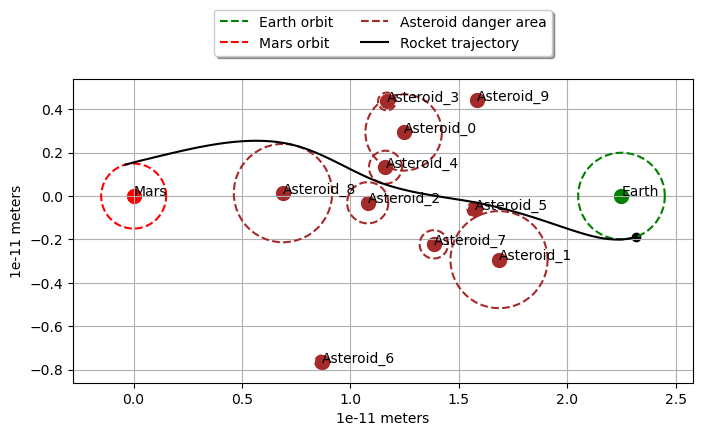

In [12]:
plt.figure()
plot_state_trajectory(state_opt, universe)

Here are the ratios between the 2 norm of the rocket thrust and velocity and their maximum values.
Note that we would like these ratios not to exceed one (labeled as "Limit" in the plot).

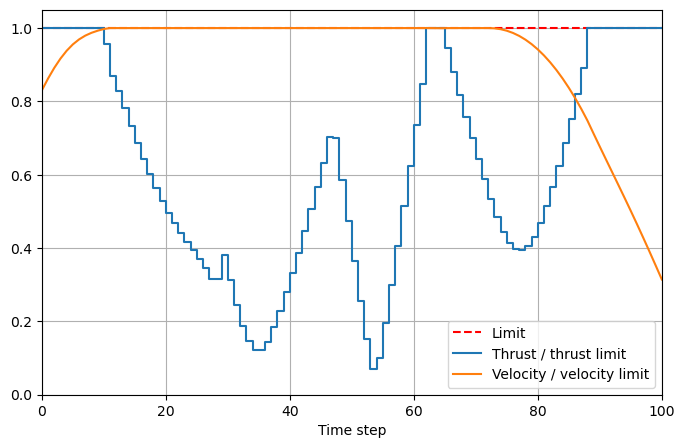

In [13]:
plt.figure()
plot_rocket_limits(rocket, thrust_opt, state_opt)

## Your Time to Code

As you can see, the current trajectory has several issues.
First of all it, collides with the asteroids.
Second, it exceeds both the thrust and velocity limits.

We left a cell with comments only in the center of the definition of the optimization problem.
Your goal is to work on that cell to improve the rocket trajectory.

You're required to add three groups of constraints:
- **Thrust limits.**
The class `Rocket` has the attribute `thrust_limit`.
For each time step `t`, add a constraint that requires the norm of the rocket thrust vector to be lower or equal to the `thrust_limit`.
- **Velocity limits.**
For each time step `t`, add a constraint that requires the norm of the rocket velocity (third and fourth components of the state) to be lower or equal to the `velocity_limit` from the `Rocket` class.
- **Avoid collision with asteroids.**
Each asteroid in the `universe` has the attribute `orbit`.
This is the radius of a danger orbit where we don't want our rocket to end up.
For each time step `t` and for each asteroid, add a constraint that requires distance between the rocket and the asteroid to be greater or equal to the asteroid's `orbit`.
- **Minimize fuel consumption.**
To ensure that all these extra constraints do not lead to crazy trajectories, add an objective function that minimizes the (discrete-time approximation) of the integral of the thrust squared: $$h \sum_{t=0}^{T-1} \| \mathbf{u}[t] \|^2,$$ where $h$ is the time interval (`time_interval` in the code), $t$ is the time step, $T$ is the number of time steps (`time_steps` in the code), $\mathbf{u}[t]$ is the 2D thrust at discrete time $t$ (`thrust[t]` in the code).
The current fuel consumption can be verifies using the function `fuel_consumption` defined above.
The goal for you is to keep the consumption lower than 250 (expressed in the scaled units).


If you're struggling trying to find the right functions to complete your task, here are two great resources:
- [Drake's MathematicalProgram documentation](https://drake.mit.edu/doxygen_cxx/classdrake_1_1solvers_1_1_mathematical_program.html).
This is the `C++` documentation, but it's very useful to see which methods `MathematicalProgram` implements and what you need to pass to them.
- [Drake's nonlinear-programming tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/nonlinear_program-cf0261a7a21b4bffa90140b0e30d1630).
Here you'll find usage examples of all the `MathematicalProgram` methods you need to complete this exercise.

**Troubleshooting:**
Nonlinear optimization solvers are extremely sensitive.
Different OSs can give different results.
Even worse, sometimes, enforcing the same constraints in a different order, you can make these solvers find a solution to a problem that they previously said was infeasible!
In our Deepnote testing, we implemented the constraints in the order given above, and we got full score.
However, in case you believe that your implementation is correct but you still don't get full score from the autograder, feel free to play with the initial-guess parameters (e.g. the random seed).

## Autograding
You can check your work by running the following cell.

In [14]:
from underactuated.exercises.grader import Grader
from underactuated.exercises.trajopt.test_orbital_transfer import TestOrbitalTransfer

Grader.grade_output([TestOrbitalTransfer], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 15/15.

Score for Test asteroid collision is 6/6.

Score for Test fuel consumption is 3/3.

Score for Test thrust limits is 3/3.

Score for Test velocity limits is 3/3.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9e28fe11-673c-416c-8748-667a77031cd4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>